# EffNet-SVM Hybrid for Diabetic Retinopathy Classification

This notebook implements the hybrid approach from the paper _EffNet-SVM: A Hybrid Model for Diabetic Retinopathy Classification_.

It extracts deep features using EfficientNetV2-Small (GAP) and trains an SVM (RBF) on those features. It also includes an optional classification head (CNN) for Grad-CAM visualizations.

Edit the paths in the configuration cell before running.

In [1]:
# Cell 0: Config - edit paths & params
import os
DATA_CSV = "aptos2019-blindness-detection/train.csv"
IMAGE_DIR = "aptos2019-blindness-detection/train_images"
OUTPUT_DIR = "effnet_svm_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = (224, 224)          # paper uses 224x224
BATCH_SIZE = 32
RANDOM_STATE = 42

# SVM gridsearch params (small grid to save time; expand if you want)
SVM_PARAM_GRID = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001]
}

print("Configuration set. DATA_CSV:", DATA_CSV, "IMAGE_DIR:", IMAGE_DIR)

Configuration set. DATA_CSV: aptos2019-blindness-detection/train.csv IMAGE_DIR: aptos2019-blindness-detection/train_images


In [2]:
# Cell 1: imports & dataset load
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
import joblib
import time

# Load CSV
df = pd.read_csv(DATA_CSV)
df.rename(columns={df.columns[0]:'id_code', df.columns[1]:'diagnosis'}, inplace=True)
df['id_code'] = df['id_code'].astype(str) + ".png"

# Map to binary: 0 -> no DR, 1..4 -> DR (paper groups into binary)
df['label_binary'] = df['diagnosis'].astype(int).apply(lambda x: 0 if x==0 else 1)

# Quick sanity
print("Total images:", len(df))
print("Class distribution:\n", df['label_binary'].value_counts())

Total images: 3662
Class distribution:
 label_binary
1    1857
0    1805
Name: count, dtype: int64


In [3]:
# Cell 2: Split and generators
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label_binary'], random_state=RANDOM_STATE)
train_df, val_df = train_test_split(train_df, test_size=0.125, stratify=train_df['label_binary'], random_state=RANDOM_STATE)
# Splits -> roughly train 70%, val 10%, test 20%

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

# Augmentation pipeline (includes rotations, flips, brightness)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.7, 1.3),
    fill_mode='nearest'
)

eval_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, IMAGE_DIR, x_col='id_code', y_col='label_binary',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='raw', shuffle=True
)
val_gen = eval_datagen.flow_from_dataframe(
    val_df, IMAGE_DIR, x_col='id_code', y_col='label_binary',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='raw', shuffle=False
)
test_gen = eval_datagen.flow_from_dataframe(
    test_df, IMAGE_DIR, x_col='id_code', y_col='label_binary',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='raw', shuffle=False
)

Train: 2562 Val: 367 Test: 733
Found 2557 validated image filenames.
Found 367 validated image filenames.
Found 733 validated image filenames.


/home/user/.local/lib/python3.8/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 5 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(


In [4]:
# Cell 3: Build base feature extractor
try:
    from tensorflow.keras.applications import EfficientNetV2S
    base = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("Using EfficientNetV2S from tf.keras.applications")
except Exception as e:
    print("EfficientNetV2S not found in this TF build. Falling back to EfficientNetB0. Error:", e)
    from tensorflow.keras.applications import EfficientNetB0 as EfficientNetV2S
    base = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze base initially
base.trainable = False

# Add GAP to get feature vector
x = GlobalAveragePooling2D()(base.output)
feature_model = Model(inputs=base.input, outputs=x, name='effnet_feature_extractor')

feature_model.summary()

Using EfficientNetV2S from tf.keras.applications
Model: "effnet_feature_extractor"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 24)         648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 24)         96        ['stem_conv[0][0]']           
 n)                       

 rmalization)                                                                                     
                                                                                                  
 block2c_expand_activation   (None, 56, 56, 192)          0         ['block2c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block2c_project_conv (Conv  (None, 56, 56, 48)           9216      ['block2c_expand_activation[0]
 2D)                                                                [0]']                         
                                                                                                  
 block2c_project_bn (BatchN  (None, 56, 56, 48)           192       ['block2c_project_conv[0][0]']
 ormalization)                                                                                    
          

 block3c_project_bn (BatchN  (None, 28, 28, 64)           256       ['block3c_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3c_drop (Dropout)      (None, 28, 28, 64)           0         ['block3c_project_bn[0][0]']  
                                                                                                  
 block3c_add (Add)           (None, 28, 28, 64)           0         ['block3c_drop[0][0]',        
                                                                     'block3b_add[0][0]']         
                                                                                                  
 block3d_expand_conv (Conv2  (None, 28, 28, 256)          147456    ['block3c_add[0][0]']         
 D)                                                                                               
          

 block4b_se_squeeze (Global  (None, 512)                  0         ['block4b_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block4b_se_reshape (Reshap  (None, 1, 1, 512)            0         ['block4b_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block4b_se_reduce (Conv2D)  (None, 1, 1, 32)             16416     ['block4b_se_reshape[0][0]']  
                                                                                                  
 block4b_se_expand (Conv2D)  (None, 1, 1, 512)            16896     ['block4b_se_reduce[0][0]']   
                                                                                                  
 block4b_s

                                                                                                  
 block4d_se_squeeze (Global  (None, 512)                  0         ['block4d_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block4d_se_reshape (Reshap  (None, 1, 1, 512)            0         ['block4d_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block4d_se_reduce (Conv2D)  (None, 1, 1, 32)             16416     ['block4d_se_reshape[0][0]']  
                                                                                                  
 block4d_se_expand (Conv2D)  (None, 1, 1, 512)            16896     ['block4d_se_reduce[0][0]']   
          

 tion)                                                                                            
                                                                                                  
 block4f_se_squeeze (Global  (None, 512)                  0         ['block4f_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block4f_se_reshape (Reshap  (None, 1, 1, 512)            0         ['block4f_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block4f_se_reduce (Conv2D)  (None, 1, 1, 32)             16416     ['block4f_se_reshape[0][0]']  
                                                                                                  
 block4f_s

                                                                                                  
 block5b_se_reshape (Reshap  (None, 1, 1, 960)            0         ['block5b_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5b_se_reduce (Conv2D)  (None, 1, 1, 40)             38440     ['block5b_se_reshape[0][0]']  
                                                                                                  
 block5b_se_expand (Conv2D)  (None, 1, 1, 960)            39360     ['block5b_se_reduce[0][0]']   
                                                                                                  
 block5b_se_excite (Multipl  (None, 14, 14, 960)          0         ['block5b_activation[0][0]',  
 y)                                                                  'block5b_se_expand[0][0]']   
          

 AveragePooling2D)                                                                                
                                                                                                  
 block5d_se_reshape (Reshap  (None, 1, 1, 960)            0         ['block5d_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5d_se_reduce (Conv2D)  (None, 1, 1, 40)             38440     ['block5d_se_reshape[0][0]']  
                                                                                                  
 block5d_se_expand (Conv2D)  (None, 1, 1, 960)            39360     ['block5d_se_reduce[0][0]']   
                                                                                                  
 block5d_se_excite (Multipl  (None, 14, 14, 960)          0         ['block5d_activation[0][0]',  
 y)       

 block5f_se_squeeze (Global  (None, 960)                  0         ['block5f_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block5f_se_reshape (Reshap  (None, 1, 1, 960)            0         ['block5f_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5f_se_reduce (Conv2D)  (None, 1, 1, 40)             38440     ['block5f_se_reshape[0][0]']  
                                                                                                  
 block5f_se_expand (Conv2D)  (None, 1, 1, 960)            39360     ['block5f_se_reduce[0][0]']   
                                                                                                  
 block5f_s

                                                                                                  
 block5h_se_squeeze (Global  (None, 960)                  0         ['block5h_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block5h_se_reshape (Reshap  (None, 1, 1, 960)            0         ['block5h_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block5h_se_reduce (Conv2D)  (None, 1, 1, 40)             38440     ['block5h_se_reshape[0][0]']  
                                                                                                  
 block5h_se_expand (Conv2D)  (None, 1, 1, 960)            39360     ['block5h_se_reduce[0][0]']   
          

 tion)                                                                                            
                                                                                                  
 block6a_se_squeeze (Global  (None, 960)                  0         ['block6a_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6a_se_reshape (Reshap  (None, 1, 1, 960)            0         ['block6a_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6a_se_reduce (Conv2D)  (None, 1, 1, 40)             38440     ['block6a_se_reshape[0][0]']  
                                                                                                  
 block6a_s

                                                                                                  
 block6c_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6c_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6c_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6c_se_reshape[0][0]']  
                                                                                                  
 block6c_se_expand (Conv2D)  (None, 1, 1, 1536)           99840     ['block6c_se_reduce[0][0]']   
                                                                                                  
 block6c_se_excite (Multipl  (None, 7, 7, 1536)           0         ['block6c_activation[0][0]',  
 y)                                                                  'block6c_se_expand[0][0]']   
          

 AveragePooling2D)                                                                                
                                                                                                  
 block6e_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6e_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6e_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6e_se_reshape[0][0]']  
                                                                                                  
 block6e_se_expand (Conv2D)  (None, 1, 1, 1536)           99840     ['block6e_se_reduce[0][0]']   
                                                                                                  
 block6e_se_excite (Multipl  (None, 7, 7, 1536)           0         ['block6e_activation[0][0]',  
 y)       

 block6g_se_squeeze (Global  (None, 1536)                 0         ['block6g_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6g_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6g_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6g_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6g_se_reshape[0][0]']  
                                                                                                  
 block6g_se_expand (Conv2D)  (None, 1, 1, 1536)           99840     ['block6g_se_reduce[0][0]']   
                                                                                                  
 block6g_s

                                                                                                  
 block6i_se_squeeze (Global  (None, 1536)                 0         ['block6i_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6i_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6i_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6i_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6i_se_reshape[0][0]']  
                                                                                                  
 block6i_se_expand (Conv2D)  (None, 1, 1, 1536)           99840     ['block6i_se_reduce[0][0]']   
          

 tion)                                                                                            
                                                                                                  
 block6k_se_squeeze (Global  (None, 1536)                 0         ['block6k_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6k_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6k_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6k_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6k_se_reshape[0][0]']  
                                                                                                  
 block6k_s

 block6m_activation (Activa  (None, 7, 7, 1536)           0         ['block6m_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block6m_se_squeeze (Global  (None, 1536)                 0         ['block6m_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6m_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6m_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6m_se_reduce (Conv2D)  (None, 1, 1, 64)             98368     ['block6m_se_reshape[0][0]']  
          

                                                                                                  
 block6o_activation (Activa  (None, 7, 7, 1536)           0         ['block6o_bn[0][0]']          
 tion)                                                                                            
                                                                                                  
 block6o_se_squeeze (Global  (None, 1536)                 0         ['block6o_activation[0][0]']  
 AveragePooling2D)                                                                                
                                                                                                  
 block6o_se_reshape (Reshap  (None, 1, 1, 1536)           0         ['block6o_se_squeeze[0][0]']  
 e)                                                                                               
                                                                                                  
 block6o_s

In [5]:
# Cell 4: Extract & save features
def extract_features(generator, feature_model, desc="set"):
    steps = int(np.ceil(generator.n / generator.batch_size))
    print(f"Extracting features for {desc}, steps={steps}, samples={generator.n}")
    features = feature_model.predict(generator, steps=steps, verbose=1)
    labels = generator.labels[:len(features)]
    return features, labels

t0 = time.time()
train_feats, train_labels = extract_features(train_gen, feature_model, "train")
val_feats, val_labels = extract_features(val_gen, feature_model, "val")
test_feats, test_labels = extract_features(test_gen, feature_model, "test")
print("Feature extraction time (s):", time.time() - t0)

# Save features for reproducibility
import numpy as np
np.save(os.path.join(OUTPUT_DIR, "train_feats.npy"), train_feats)
np.save(os.path.join(OUTPUT_DIR, "val_feats.npy"), val_feats)
np.save(os.path.join(OUTPUT_DIR, "test_feats.npy"), test_feats)
np.save(os.path.join(OUTPUT_DIR, "train_labels.npy"), train_labels)
np.save(os.path.join(OUTPUT_DIR, "val_labels.npy"), val_labels)
np.save(os.path.join(OUTPUT_DIR, "test_labels.npy"), test_labels)
print("Saved feature arrays to", OUTPUT_DIR)

Extracting features for train, steps=80, samples=2557
80/80 [==============================] - 307s 4s/step
Extracting features for val, steps=12, samples=367
12/12 [==============================] - 44s 4s/step
Extracting features for test, steps=23, samples=733
23/23 [==============================] - 89s 4s/step
Feature extraction time (s): 448.3032567501068
Saved feature arrays to effnet_svm_outputs


In [6]:
# Cell 5: SVM training (pipeline + gridsearch)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
svc = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_STATE)

pipeline = Pipeline([('scaler', scaler), ('svc', svc)])

# Grid search (wrap SVC params as svc__C, svc__gamma)
param_grid = {'svc__C': SVM_PARAM_GRID['C'], 'svc__gamma': SVM_PARAM_GRID['gamma']}
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='balanced_accuracy', verbose=2, n_jobs=-1)

print("Starting GridSearchCV for SVM ...")
t0 = time.time()
grid.fit(train_feats, train_labels)
print("Grid search done. Time (s):", time.time()-t0)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# Best model
best_svm = grid.best_estimator_

# Evaluate on validation and test
val_preds = best_svm.predict(val_feats)
test_preds = best_svm.predict(test_feats)
val_probs = best_svm.predict_proba(val_feats)[:,1]
test_probs = best_svm.predict_proba(test_feats)[:,1]

print("Validation classification report:")
print(classification_report(val_labels, val_preds, digits=4))
print("Test classification report:")
print(classification_report(test_labels, test_preds, digits=4))

# Save the SVM pipeline
import joblib
joblib.dump(best_svm, os.path.join(OUTPUT_DIR, "effnet_svm_pipeline.joblib"))
print("Saved SVM pipeline to", OUTPUT_DIR)

Starting GridSearchCV for SVM ...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Grid search done. Time (s): 241.5176932811737
Best params: {'svc__C': 10, 'svc__gamma': 0.001}
Best CV score: 0.5246471118700949
Validation classification report:
              precision    recall  f1-score   support

           0     0.3819    0.3039    0.3385       181
           1     0.4350    0.5215    0.4743       186

    accuracy                         0.4142       367
   macro avg     0.4085    0.4127    0.4064       367
weighted avg     0.4088    0.4142    0.4073       367

Test classification report:
              precision    recall  f1-score   support

           0     0.3533    0.2936    0.3207       361
           1     0.4111    0.4785    0.4422       372

    accuracy                         0.3874       733
   macro avg     0.3822    0.3861    0.3815       733
weighted avg     0.3826    0.3874    0.3824       733

Saved SVM pipeline to effnet_svm_outputs


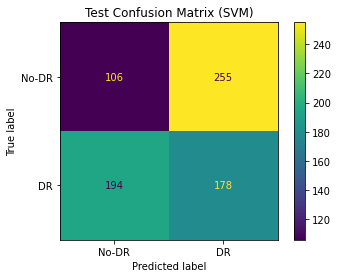

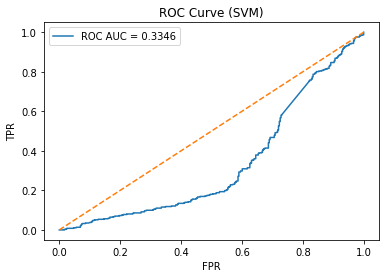

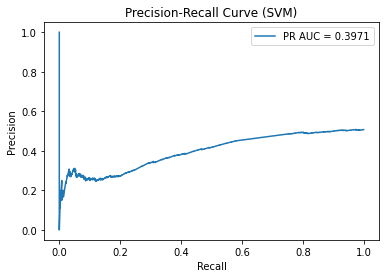

In [7]:
# Cell 6: Metrics & plots
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, auc

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No-DR', 'DR'])
disp.plot(values_format='d')
plt.title("Test Confusion Matrix (SVM)")
plt.show()

# ROC
roc_auc = roc_auc_score(test_labels, test_probs)
fpr, tpr, _ = roc_curve(test_labels, test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve (SVM)'); plt.legend(); plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(test_labels, test_probs)
pr_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve (SVM)'); plt.legend(); plt.show()

In [9]:
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# ---- Settings ----
IMG_SIZE = (128, 128)
BATCH_SIZE = 10
STEPS_PER_EPOCH = 20    # 20 batches × 10 images = 200 images
EPOCHS = 5
OUTPUT_DIR = "effnet_fast_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---- Load EfficientNetV2S base ----
try:
    base_cls = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
except Exception as e:
    from tensorflow.keras.applications import EfficientNetB0 as EfficientNetV2S
    base_cls = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    print("Fallback used:", e)

# ---- Classification head ----
x = GlobalAveragePooling2D()(base_cls.output)
x = Dropout(0.3)(x)
out = Dense(1, activation='sigmoid')(x)
cls_model = Model(inputs=base_cls.input, outputs=out)

# ---- Freeze all except last 20 layers ----
for layer in base_cls.layers[:-20]:
    layer.trainable = False
for layer in base_cls.layers[-20:]:
    layer.trainable = True

cls_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ---- Data Generators ----
train_sample_df = train_df.sample(STEPS_PER_EPOCH * BATCH_SIZE, random_state=42).reset_index(drop=True)
val_sample_df = val_df.sample(STEPS_PER_EPOCH * BATCH_SIZE, random_state=42).reset_index(drop=True)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_sample_df,
    directory=IMAGE_DIR,
    x_col='id_code',
    y_col='label_binary',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True
)

val_gen = eval_datagen.flow_from_dataframe(
    dataframe=val_sample_df,
    directory=IMAGE_DIR,
    x_col='id_code',
    y_col='label_binary',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

# ---- Callbacks ----
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'effnet_cls_fast.h5'),  # <-- HDF5 format for callbacks
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
]

# ---- Train model ----
history = cls_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=STEPS_PER_EPOCH,
    verbose=2,
    callbacks=callbacks
)

# ---- Save final model in native Keras format (.keras) ----
cls_model.save(os.path.join(OUTPUT_DIR, "effnet_cls_full_fast.keras"))
print("✅ Saved fast EfficientNetV2S model to", OUTPUT_DIR)


Found 199 validated image filenames.
Found 200 validated image filenames.


/home/user/.local/lib/python3.8/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/5

Epoch 1: val_loss improved from inf to 0.66260, saving model to effnet_fast_outputs/effnet_cls_fast.h5


/home/user/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 - 52s - loss: 0.7115 - accuracy: 0.4623 - val_loss: 0.6626 - val_accuracy: 0.7300 - 52s/epoch - 3s/step
Epoch 2/5

Epoch 2: val_loss improved from 0.66260 to 0.57199, saving model to effnet_fast_outputs/effnet_cls_fast.h5
20/20 - 40s - loss: 0.6658 - accuracy: 0.6382 - val_loss: 0.5720 - val_accuracy: 0.7700 - 40s/epoch - 2s/step
Epoch 3/5

Epoch 3: val_loss improved from 0.57199 to 0.56199, saving model to effnet_fast_outputs/effnet_cls_fast.h5
20/20 - 39s - loss: 0.6614 - accuracy: 0.6030 - val_loss: 0.5620 - val_accuracy: 0.7900 - 39s/epoch - 2s/step
Epoch 4/5

Epoch 4: val_loss did not improve from 0.56199
20/20 - 39s - loss: 0.6413 - accuracy: 0.6683 - val_loss: 0.6053 - val_accuracy: 0.6600 - 39s/epoch - 2s/step
Epoch 5/5

Epoch 5: val_loss did not improve from 0.56199
20/20 - 39s - loss: 0.6079 - accuracy: 0.6683 - val_loss: 0.5881 - val_accuracy: 0.7600 - 39s/epoch - 2s/step
✅ Saved fast EfficientNetV2S model to effnet_fast_outputs


Using last conv layer: top_conv
1/1 [==============================] - 0s 41ms/step


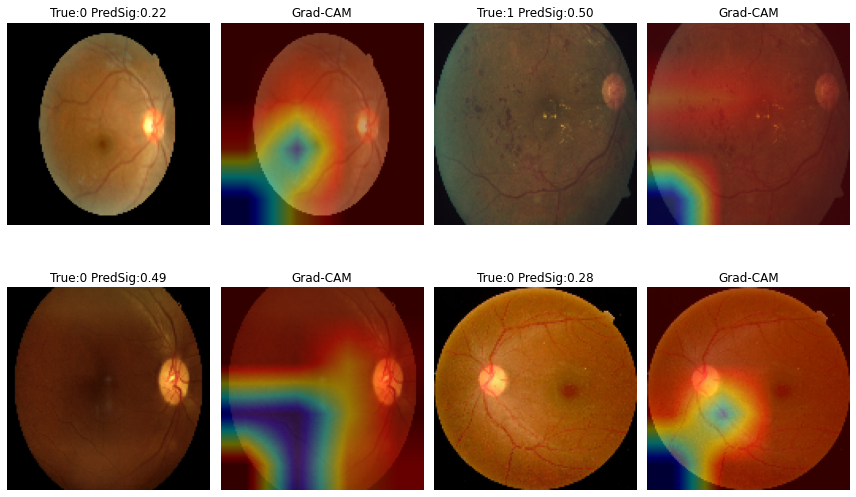

In [10]:
# Cell 8: Grad-CAM visualization (uses cls_model)
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = int(tf.round(predictions[0][0]))
        loss = predictions[:, 0] if pred_index == 1 else (1 - predictions[:, 0])
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# find last conv layer name
last_conv = None
for layer in reversed(cls_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv = layer.name
        break
if last_conv is None:
    for layer in reversed(cls_model.layers):
        if 'block' in layer.name:
            last_conv = layer.name
            break
print("Using last conv layer:", last_conv)

# visualize few samples from test_df
sample = test_df.sample(4, random_state=RANDOM_STATE).reset_index(drop=True)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
for i, row in sample.iterrows():
    img_path = os.path.join(IMAGE_DIR, row['id_code'])
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    input_arr = np.expand_dims(img_array, axis=0)
    preds = cls_model.predict(input_arr)[0][0]
    heatmap = make_gradcam_heatmap(input_arr, cls_model, last_conv)
    heatmap = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
    heatmap = np.uint8(255 * heatmap)
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted((img_array * 255).astype(np.uint8), 0.6, jet, 0.4, 0)
    plt.subplot(2, 4, 2*i+1)
    plt.imshow(img_array); plt.title(f"True:{row['label_binary']} PredSig:{preds:.2f}")
    plt.axis('off')
    plt.subplot(2, 4, 2*i+2)
    plt.imshow(superimposed_img); plt.title("Grad-CAM")
    plt.axis('off')
plt.tight_layout(); plt.show()